#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 6
### Due: Monday, Mar 14th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on March 14th (after Spring Break).

---

## Problem 1

**The Leavitt Law**

Cepheid variable stars in galaxies follow a linear relation between their log periods, log metallicity, and apparent magnitude (the Leavitt law):

$$m_i^W = zp_{W,N4258} + b_W \log P_i + Z_w \Delta \log (O/H)_i \;\;\; (1)$$

where 
$$m^W = m_H - 0.39(V-I)$$

and is called the "Wesenheit magnitude".

The index $i$ here denotes the individual Cepheids in a sample.


Download table 4 from Riess et al. (2016):

https://ui.adsabs.harvard.edu/abs/2016yCat..18260056R/abstract

You will find the tables here:
https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJ/826/56#/browse
Table descriptions are in the readme file.

Use the data for Cepheids in NGC 4258 from Table 4. Assuming that there is no intrinsic scatter in the Leavitt law, the parameters
of Equation (1) can be determined through ordinary least squares. Determine the best-fit
parameters $zp_{W,N4258}$, $b_W$, and $Z_w$ and their Gaussian covariance matrix. Plot the data $m^W_i$ vs. $\log_{10} P_i$ and overlay the best fit model (evaluated at the mean metallicity of the sample).








In [2]:
# Import needed libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  

In [3]:
# Import the data for Cepheids in NGC 4258 into a dataframe
# README: https://cdsarc.cds.unistra.fr/viz-bin/ReadMe/J/ApJ/826/56?format=html&tex=true#sRM2.2
headers = ['Gal', 'RAdeg', 'DEdeg', 'ID', 'Per', 'V-I', 'F160W', 'sigTot', '[O/H]']
colspecs = [(0, 5), (6, 16), (17, 29), (30, 38), (39, 45), (46, 50), (51, 56), (57, 61), (63, -1)]
data = pd.read_fwf('table4.dat.txt', names=headers, colspecs=colspecs)

# Get only the Cepheids in NGC 4258
data = data.loc[data['Gal'] == 'N4258']

# Create numpy arrays to hold features and output

# Log of the Cepheid period
log_P = np.log10(data['Per']).to_numpy()

# Log of the metallicity|
log_M = (data['[O/H]']).to_numpy()

# Wesenheit magnitude using the above equation
W_mag = (data['F160W'].to_numpy()) - (0.39 * (data['V-I'].to_numpy()))

# Statistical uncertainties in Cepheid magnitude
# Propagated to fit Wesenheit magnitude
dW_mag = ((data['F160W'].to_numpy()) - (data['sigTot'].to_numpy()))
dW_mag = dW_mag - (0.39 * (data['V-I'].to_numpy()))
dW_mag = W_mag - dW_mag

In [4]:
# Define the squared loss function for ordinary least squares
# zp_w is intercept
# b_w is coefficient for log period
# Z_w is coefficient for log metallicity
# x and y are independent variables (log period and log metallicity)
# z is the dependent variable (Wesenheit magnitude)
# dz is the uncertainty in the dependent variable
def squared_loss(zp_w, b_w, Z_w, x, y, z, dz):
    z_fit = zp_w + b_w * x + Z_w * y
    return np.sum(((z - z_fit) / dz) ** 2, -1)
    #return np.sum((z - z_fit) ** 2, -1)

# Define a lambda function that defines the sum of squared errors
f_squared = lambda beta: squared_loss(beta[0], beta[1], beta[2], x=log_P, y=log_M, z=W_mag, dz=dW_mag) 

# Initial guesses
beta0 = (10, 1, -2)
beta_squared = optimize.fmin(f_squared, beta0)

print('\nThe best-fit parameters for the Leavitt equation are:\nzp_W,N4258: {}\nb_W: {}\nZ_w: {}'.format(
        beta_squared[0], beta_squared[1], beta_squared[2]))

Optimization terminated successfully.
         Current function value: 137.135838
         Iterations: 166
         Function evaluations: 305

The best-fit parameters for the Leavitt equation are:
zp_W,N4258: 24.924068410069655
b_W: -3.1415231893487086
Z_w: 0.17737580035327705


<IPython.core.display.Javascript object>


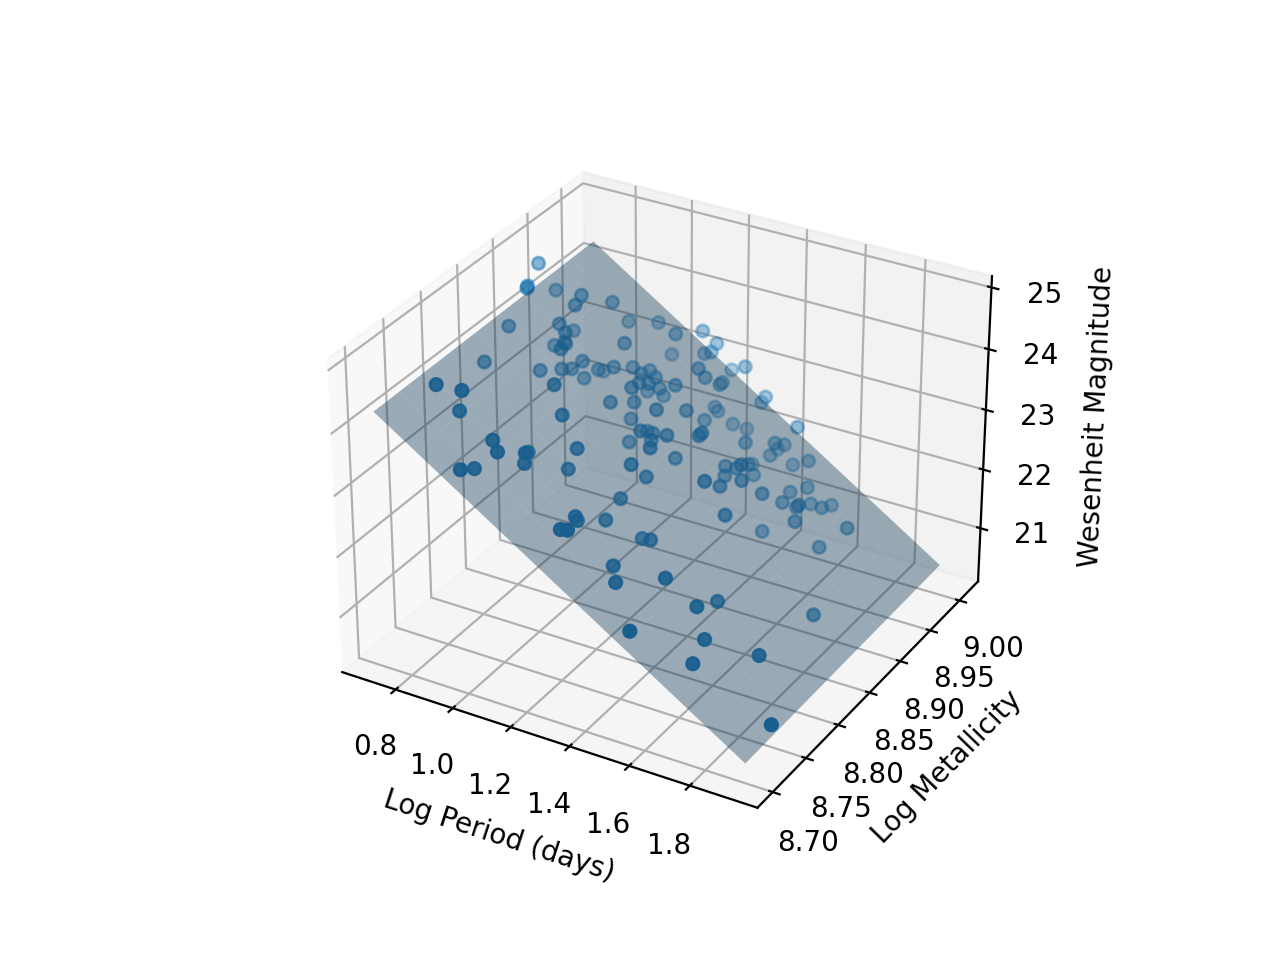

In [5]:
# Make it so that 3D plot can be manipulated
%matplotlib notebook

# Plot the data in 3D with best fit plane
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot the data
ax.scatter(log_P, log_M , W_mag)

ax.set_xlabel('Log Period (days)')
ax.set_ylabel('Log Metallicity')
ax.set_zlabel('Wesenheit Magnitude')

# Plot the best fit plane
x = np.linspace(0.7, 1.93, 10)
y = np.linspace(8.7, 9.01, 10)

X,Y = np.meshgrid(x,y)

Z = (beta_squared[0] + beta_squared[1]*X + beta_squared[2]*Y)
surf = ax.plot_surface(X, Y, Z, alpha=0.4)

plt.show()

In [6]:
# Calculate the Gaussian covariance matrix
# Using information from page 4 of the following article: https://arxiv.org/pdf/1008.4686.pdf

# Construct the matrices
Y = W_mag.reshape(-1,1)

A = np.concatenate((log_P.reshape(-1,1), log_M.reshape(-1,1)), axis=1)

# Covariance matrix using NumPy's .cov() function
print('The Gaussian covariance matrix for log period, log metallicity, and apparent magnitude of Cepheids is:\n')
print(np.cov(A, Y, rowvar=False))

The Gaussian covariance matrix for log period, log metallicity, and apparent magnitude of Cepheids is:

[[ 0.06958968  0.00115202 -0.2203592 ]
 [ 0.00115202  0.00610511 -0.00400779]
 [-0.2203592  -0.00400779  0.81793162]]


<IPython.core.display.Javascript object>


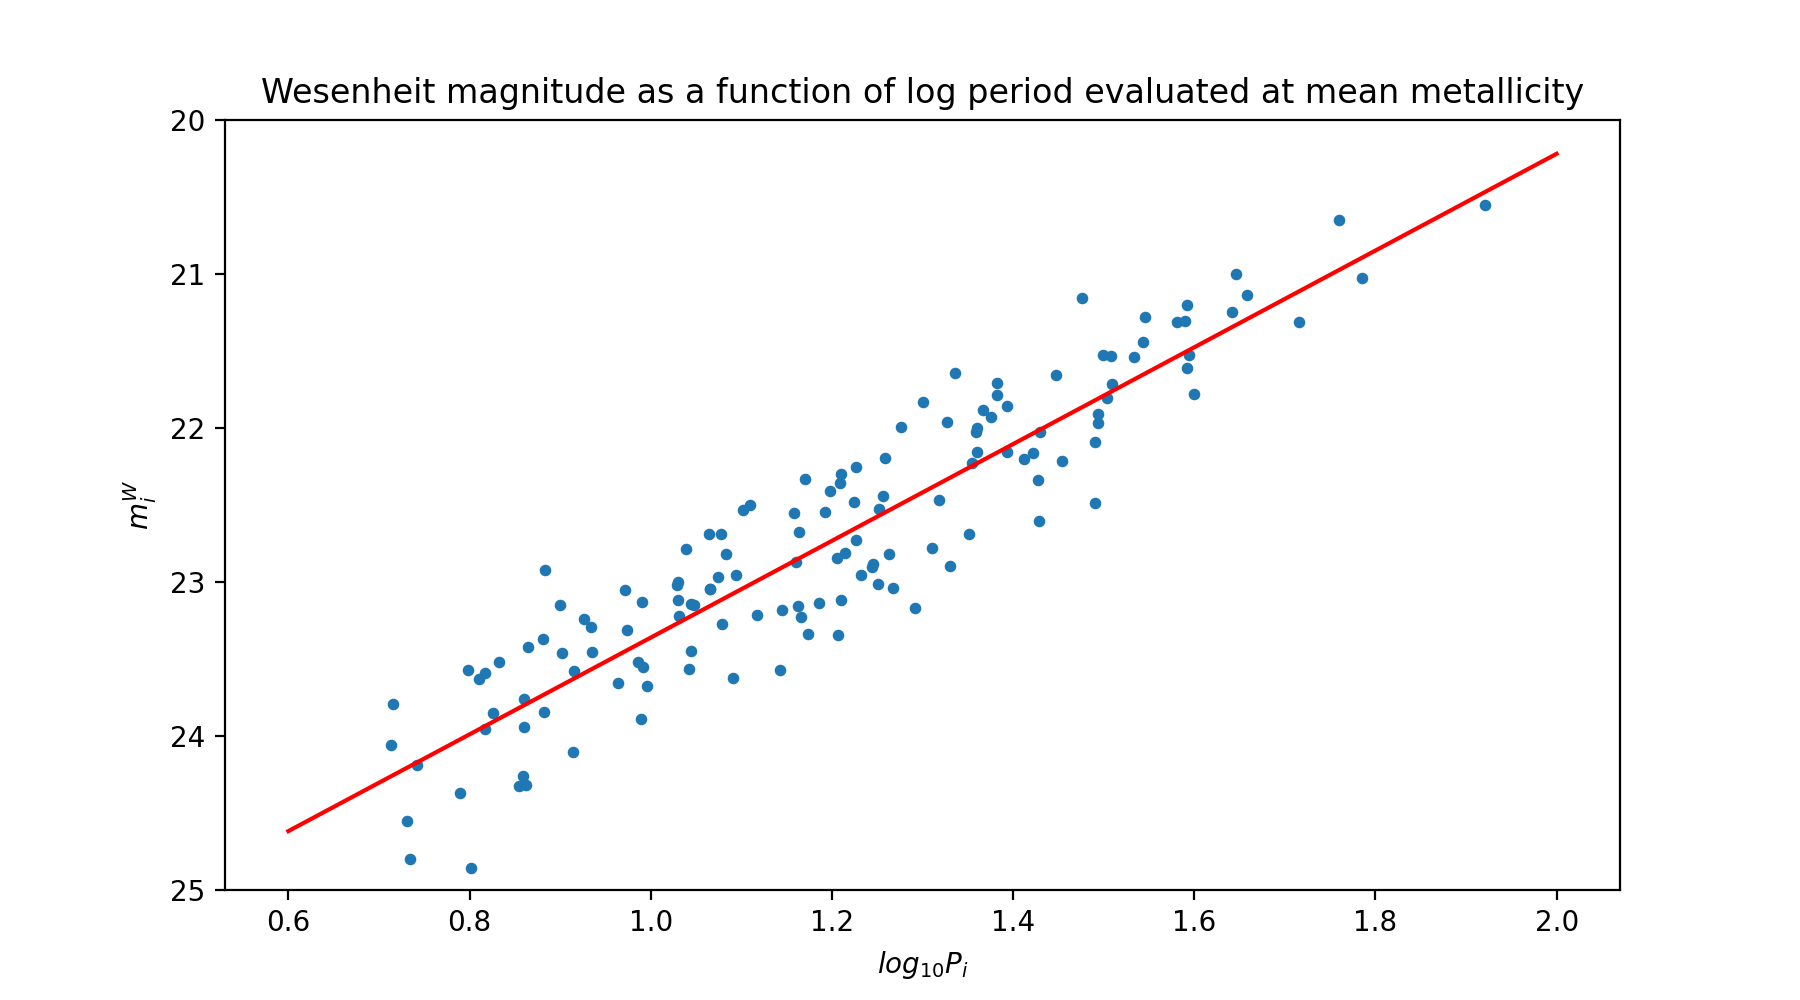

In [12]:
# Plot the data m_i^w vs log10(P_i) and overlay the best fit model evaluated at the mean metallicity of the sample
%matplotlib inline

# Scatter plot of data in blue
plt.figure(figsize=(9, 5))
plt.scatter(log_P, W_mag, s=10)

# Overlay best fit model at mean metallicity in red
x = np.linspace(0.6, 2.0, 100)
y = beta_squared[0] + beta_squared[1]*x + beta_squared[2]*(np.mean(log_M))
plt.plot(x, y, color='red')

plt.xlabel('$log_{10}P_{i}$')
plt.ylabel('$m_{i}^{W}$')
plt.ylim(25, 20) #Invert y-axis to reflect that magnitude is indirectly related to brightness
plt.title('Wesenheit magnitude as a function of log period evaluated at mean metallicity')
plt.show()

### Solution

## Problem 2

**Posterior probability distribution of binomial distribution**

Given a set of $N$ measurements, $x_i$, drawn from a binomial distribution described with parameter $b$, we seek the posterior probability distribution $p(b|x_i)$.

When $N$ is large, $b$ and its (presumably Gaussian) uncertainty $\sigma_b$ can be determined using the equation above. For small $N$, the proper procedure is as follows. Assuming that the prior for $b$ is at in the range 0-1, the posterior probability for $b$ is

$$p(b|k,N) = C b^k (1-b)^{N-k}$$

where $k$ is now the actual observed number of successes in a data set of $N$ values, and $C$ is a normalization factor with can be determined from the condition

$$\int_0 ^1 p(b|k,N)db=1.$$

The maximum posterior occurs at $b_0 = k/N$.

Write code for calculating the posterior distribution.
Vary the value $b$ and draw the resulted posterior probability distribution from our data set. 

In comparison, also calculate a Gaussian distribution from the same data set.


### Solution



#### Calculating the posterior distribution by varying the value of b:

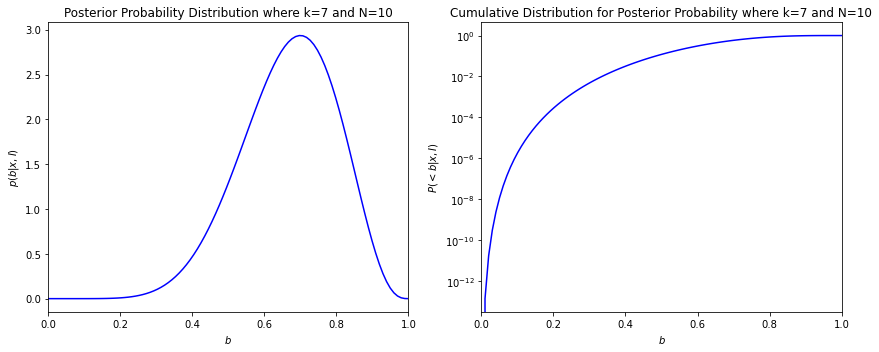

In [152]:
# Code adapted from https://www.astroml.org/astroML-notebooks/chapter5/astroml_chapter5_Parameter_Estimation_for_Binomial_Distribution.html
%matplotlib inline

# Set size of data set (small)
N = 10

# Set observed number of successes
k = 7

# Set b to be 100 different values between 0 and 1
b = np.linspace(0, 1, 100)

# db is the same for every value of b given the nature of the linspace() function
db = b[1] - b[0]

# Calculate the posterior probability for different b values using equation
p_b = b ** k * (1 - b) ** (N - k)

# Normalize
p_b /= p_b.sum()
p_b /= db

# Calculate cumulative distribution of posterior probability
p_b_cuml = p_b.cumsum()

# Normalize so values are between 0 and 1 (percentages)
p_b_cuml /= p_b_cuml[-1]

# Plot the posterior probability distribution as a function of b

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(b, p_b, '-b')
ax[0].set_title(f'Posterior Probability Distribution where k={k} and N={N}')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel('$b$')
ax[0].set_ylabel('$p(b|x,I)$')

# Plot corresponding cumulative distribution

ax[1].plot(b, p_b_cuml, '-b')
ax[1].set_yscale('log')
ax[1].set_title(f'Cumulative Distribution for Posterior Probability where k={k} and N={N}')
ax[1].set_xlim(0, 1)
ax[1].set_xlabel('$b$')
ax[1].set_ylabel('$P(<b|x,I)$')

plt.tight_layout()
plt.show()

It makes sense that the peak in the posterior probability distribution occurs at the maximum posterior where b=k/N.

#### Calculating a Gaussian distribution from the same dataset:

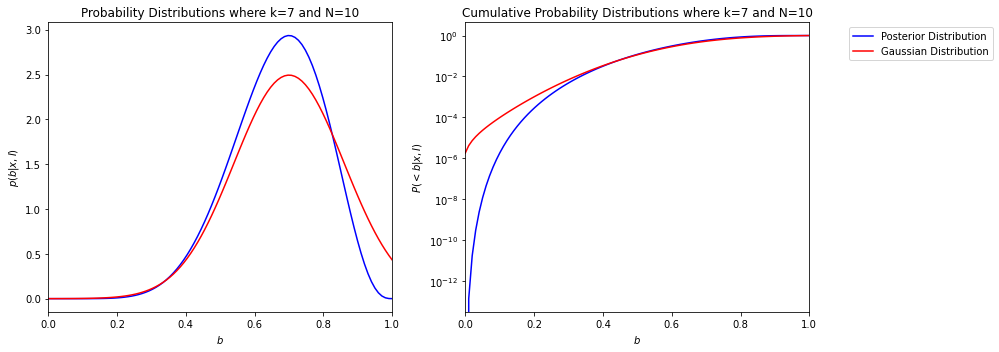

In [170]:
%matplotlib inline

# Get the Gaussian distribution using scipy.stats.norm()
# Mu is where peak in probability occurs (k/N)
sigma = 0.16
p_g = norm(k * 1. / N, sigma).pdf(b)

# Calculate corresponding cumulative distribution
p_g_cuml = p_g.cumsum()

# Normalize so values are between 0 and 1 (percentages)
p_g_cuml /= p_g_cuml[-1]

# Create same plots as above, but add the Gaussian distribution in red
# Plot the probability distributions as a function of b

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(b, p_b, '-b')
ax[0].plot(b, p_g, '-r')
ax[0].set_title(f'Probability Distributions where k={k} and N={N}')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel('$b$')
ax[0].set_ylabel('$p(b|x,I)$')

# Plot corresponding cumulative distributions

ax[1].plot(b, p_b_cuml, '-b', label='Posterior Distribution')
ax[1].plot(b, p_g_cuml, '-r', label='Gaussian Distribution')
ax[1].set_yscale('log')
ax[1].set_title(f'Cumulative Probability Distributions where k={k} and N={N}')
ax[1].set_xlim(0, 1)
ax[1].set_xlabel('$b$')
ax[1].set_ylabel('$P(<b|x,I)$')
ax[1].legend(bbox_to_anchor=(1.1, 1.0))

plt.tight_layout()
plt.show()

There are some key similarities and differences between the posterior distribution and the Gaussian distribution. Both distributions have a bell shape that peaks where b=k/N. However, the "bell" for the posterior has a slight skew depending upon the value of k. There does not appear to be any skew when k = 5, but the distribution seems to be positively skewed when k < 5 and negatively skewed when k > 5. Depending upon the standard deviation given, the Guassian might also appear to be wider or narrower than the posterior. In the above case, the Gaussian is a bit wider and shorter. In addition, the cumulative distributions for each are a bit different. For this value of sigma, they look largely the same after a certain value of b. However, some lesser values of b are much more likely according to the Gaussian distribution than they are according to the posterior.